In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report
import math
import numpy as np

#from yellowbrick.regressor import ResidualsPlot

##  Carrega dados

In [2]:
df = pd.DataFrame()

df_apartamentos = pd.read_csv("data/apartamentos_completo.csv")
df_apartamentos['tipo'] = 'apartamento'

df_casas = pd.read_csv("data/casas_completo.csv")
df_casas['tipo'] = 'casa'

df = df_apartamentos.append(df_casas)

df = df.drop(['Unnamed: 0'],axis=1)
df.reset_index(inplace=True,drop=True)
print(df.shape)
df.head()

(49348, 18)


,nome,valor_venda,url,condominio,IPTU,lat,long,area_total,area_util,banheiros,vagas,quartos,suites,idade,endereco,bairro,idade_anuncio,tipo
0,Tower duplex 90m2,550000,https://www.wimoveis.com.br/propriedades/tower...,R$ 730,R$ 690,-15.842635250484830,-48.024645807548495,89m²,89m²,3.0,2.0,2.0,2.0,6,"Qd 206, Aguas Sul, Águas Claras",", Aguas Sul, Águas Claras",52,apartamento
1,SELECTION 36,2150000,https://www.wimoveis.com.br/propriedades/selec...,NaN,NaN,-15.742129999999999,-47.910919999999997,224m²,224m²,6.0,3.0,4.0,4.0,4,"Quadra SQNW 110, Noroeste, Brasília",", Noroeste, Brasília",6,apartamento
2,Elevador + Apartamento de 3 Quartos + Excelent...,420000,https://www.wimoveis.com.br/propriedades/eleva...,NaN,NaN,-15.739203900000000,-47.902473900000020,NaN,65m²,2.0,0.0,3.0,0.0,NaN,SCRN 706/707 BLOCO F - COMPLETO ARMÁRIOS- EXCE...,", Asa Norte, Brasília",9,apartamento
3,"01, 02 QUARTOS E LOJA COMERCIAL - MEET NOROESTE",332420,https://www.wimoveis.com.br/propriedades/01-02...,NaN,NaN,-15.748856500000000,-47.896520000000010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,apartamento
4,Elegance Park Sul de 03 Suítes,1333800,https://www.wimoveis.com.br/propriedades/elega...,NaN,NaN,-15.827143900000000,-47.952883600000010,117m²,117m²,5.0,2.0,3.0,3.0,1,"Sgcv 23, Park Sul, Brasília",", Park Sul, Brasília",8,apartamento


In [3]:
df.dtypes

nome              object
valor_venda        int64
url               object
condominio        object
IPTU              object
lat               object
long              object
area_total        object
area_util         object
banheiros        float64
vagas            float64
quartos          float64
suites           float64
idade             object
endereco          object
bairro            object
idade_anuncio     object
tipo              object
dtype: object

### Dropa imoveis que não tem latitude, longitude e área útil

In [4]:
df.dropna(subset=['lat', 'long','area_util','bairro'],inplace=True)
df.shape

(39263, 18)

### Quantidade de valores nulos por coluna

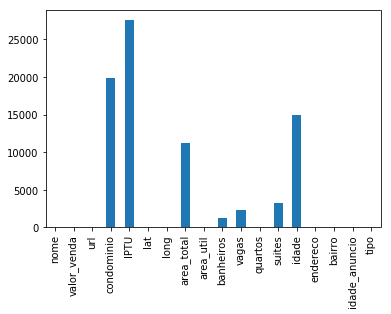

In [5]:
df.isna().sum().plot.bar()

In [6]:
df.isna().sum()

nome                 0
valor_venda          0
url                  0
condominio       19863
IPTU             27556
lat                  0
long                 0
area_total       11209
area_util            0
banheiros         1238
vagas             2322
quartos             36
suites            3168
idade            14917
endereco             0
bairro               0
idade_anuncio        0
tipo                 0
dtype: int64

### Remove outliers do preço de venda

In [7]:
print(df.shape)
df.valor_venda.describe()

(39263, 18)


count    3.926300e+04
mean     3.094572e+06
std      6.842445e+07
min      1.440000e+02
25%      3.150000e+05
50%      6.000000e+05
75%      1.148500e+06
max      7.790000e+09
Name: valor_venda, dtype: float64

### 7 bilhões parece muito para um imóvel
Vamos remover aqueles que custam a partir de 65 milhões

In [8]:
df = df.loc[df.valor_venda < 65000000]
print(df.shape)
df.valor_venda.describe()

(39143, 18)


count    3.914300e+04
mean     9.326246e+05
std      1.155998e+06
min      1.440000e+02
25%      3.100000e+05
50%      5.990000e+05
75%      1.108794e+06
max      4.000000e+07
Name: valor_venda, dtype: float64

### Remove outliers da area util

In [9]:
df.area_util = df.area_util.str.replace('m²','')
df.area_util = pd.to_numeric(df.area_util)

In [10]:
print(df.shape)
df.area_util.describe()

(39143, 18)


count    3.914300e+04
mean     2.376802e+03
std      3.647566e+05
min      1.000000e+00
25%      6.700000e+01
50%      1.140000e+02
75%      2.280000e+02
max      7.163026e+07
Name: area_util, dtype: float64

## 70 milhoes de m2  parece muito para um imóvel
Vamos remover aqueles que sao maiores que 20 mil m2

In [11]:
df = df.loc[df.area_util < 20000]
print(df.shape)
df.area_util.describe()

(39122, 18)


count    39122.000000
mean       198.949773
std        327.003492
min          1.000000
25%         67.000000
50%        114.000000
75%        228.000000
max      16300.000000
Name: area_util, dtype: float64

### Checa distribuição dos Bairros

In [12]:
df.bairro = df.bairro.str.replace(",  ","")
df.bairro.value_counts()

Aguas Sul, Águas Claras                           3497
Noroeste, Brasília                                3414
Aguas Norte, Águas Claras                         3028
Asa Norte, Brasília                               3017
Asa Sul, Brasília                                 2412
Lago Sul, Brasília                                1654
Sudoeste, Brasília                                1538
Taguatinga Norte, Taguatinga                      1391
Vicente Pires, Vicente Pires                      1335
Guara II, Guará                                   1120
Setor Habitacional Jardim Botânico, Brasília      1087
Lago Norte, Brasília                              1058
Park Way, Brasília                                 960
Park Sul, Brasília                                 710
Taguatinga Sul, Taguatinga                         684
Samambaia Sul, Samambaia                           647
Areal, Águas Claras                                555
Guara I, Guará                                     542
Samambaia 

In [13]:
bairros_goiania = ['Setor Bueno, Goiânia','Setor Marista, Goiânia','Jardim Goiás, Goiânia','Setor Oeste, Goiânia',
                  'Parque Amazônia, Goiânia','Jardim América, Goiânia']
df = df[~df['bairro'].isin(bairros_goiania)]
df.bairro.value_counts()

Aguas Sul, Águas Claras                                      3497
Noroeste, Brasília                                           3414
Aguas Norte, Águas Claras                                    3028
Asa Norte, Brasília                                          3017
Asa Sul, Brasília                                            2412
Lago Sul, Brasília                                           1654
Sudoeste, Brasília                                           1538
Taguatinga Norte, Taguatinga                                 1391
Vicente Pires, Vicente Pires                                 1335
Guara II, Guará                                              1120
Setor Habitacional Jardim Botânico, Brasília                 1087
Lago Norte, Brasília                                         1058
Park Way, Brasília                                            960
Park Sul, Brasília                                            710
Taguatinga Sul, Taguatinga                                    684
Samambaia 

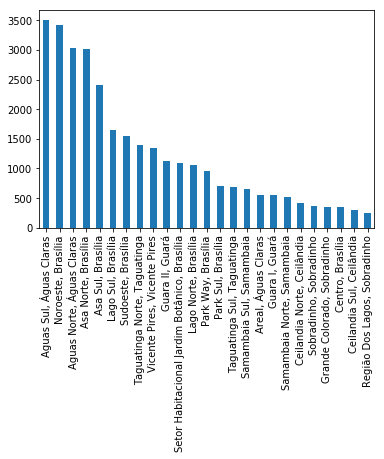

In [14]:
df.bairro.value_counts()[:25].plot.bar()

### Remove bairros com menos imóveis (pega so 25 +)

In [15]:
df.bairro.value_counts()[25:]

Riacho Fundo I, Riacho Fundo                                 220
Cruzeiro Novo, Cruzeiro                                      213
Setor Habitacional Contagem, Sobradinho                      212
Alto Da Boa Vista, Sobradinho                                160
Recanto das Emas, Recanto das Emas                           149
Arniqueiras, Águas Claras                                    132
Setor Industrial, Taguatinga                                 116
Residencial Alphaville Flamboyant, Goiânia                   108
Nucleo Bandeirante, Núcleo Bandeirante                        98
Ponte Alta, Gama                                              96
Centro, Águas Claras                                          93
Taguatinga Centro, Taguatinga                                 79
Santa Maria, Santa Maria                                      78
Riacho Fundo II, Riacho Fundo                                 75
Samambaia, Samambaia                                          74
Riacho Fundo, Riacho Fund

In [16]:
bairros_reject = df.bairro.value_counts()[25:].index.values
bairros_reject

array(['Riacho Fundo I, Riacho Fundo', 'Cruzeiro Novo, Cruzeiro',
       'Setor Habitacional Contagem, Sobradinho',
       'Alto Da Boa Vista, Sobradinho',
       'Recanto das Emas, Recanto das Emas', 'Arniqueiras, Águas Claras',
       'Setor Industrial, Taguatinga',
       'Residencial Alphaville Flamboyant, Goiânia',
       'Nucleo Bandeirante, Núcleo Bandeirante', 'Ponte Alta, Gama',
       'Centro, Águas Claras', 'Taguatinga Centro, Taguatinga',
       'Santa Maria, Santa Maria', 'Riacho Fundo II, Riacho Fundo',
       'Samambaia, Samambaia', 'Riacho Fundo, Riacho Fundo',
       'Alphaville Flamboyant Residencial Araguaia, Goiânia',
       'Colônia Agrícola Samambaia, Vicente Pires',
       'Setor Habitacional Vicente Pires, Taguatinga',
       'Taquari, Brasília', 'Jardins Valência, Goiânia',
       'Cruzeiro Velho, Cruzeiro', 'Setor Leste, Gama',
       'Quadras Economicas Lucio Costa, Guará',
       'Setor De Clubes Esportivos Norte, Brasília',
       'Residencial Santos Dumont

In [17]:
df = df[~df['bairro'].isin(bairros_reject)]
print(df.shape)
df.head()

(31192, 18)


,nome,valor_venda,url,condominio,IPTU,lat,long,area_total,area_util,banheiros,vagas,quartos,suites,idade,endereco,bairro,idade_anuncio,tipo
0,Tower duplex 90m2,550000,https://www.wimoveis.com.br/propriedades/tower...,R$ 730,R$ 690,-15.842635250484830,-48.024645807548495,89m²,89,3.0,2.0,2.0,2.0,6,"Qd 206, Aguas Sul, Águas Claras","Aguas Sul, Águas Claras",52,apartamento
1,SELECTION 36,2150000,https://www.wimoveis.com.br/propriedades/selec...,NaN,NaN,-15.742129999999999,-47.910919999999997,224m²,224,6.0,3.0,4.0,4.0,4,"Quadra SQNW 110, Noroeste, Brasília","Noroeste, Brasília",6,apartamento
2,Elevador + Apartamento de 3 Quartos + Excelent...,420000,https://www.wimoveis.com.br/propriedades/eleva...,NaN,NaN,-15.739203900000000,-47.902473900000020,NaN,65,2.0,0.0,3.0,0.0,NaN,SCRN 706/707 BLOCO F - COMPLETO ARMÁRIOS- EXCE...,"Asa Norte, Brasília",9,apartamento
4,Elegance Park Sul de 03 Suítes,1333800,https://www.wimoveis.com.br/propriedades/elega...,NaN,NaN,-15.827143900000000,-47.952883600000010,117m²,117,5.0,2.0,3.0,3.0,1,"Sgcv 23, Park Sul, Brasília","Park Sul, Brasília",8,apartamento
5,QI 31 Jardins Life Reformadíssimo Localização ...,580000,https://www.wimoveis.com.br/propriedades/qi-31...,NaN,NaN,-15.840017800000000,-47.975002600000038,NaN,68,2.0,1.0,2.0,1.0,3,"QUADRA QI 31 LOTES 2/4, Guara II, Guará","Guara II, Guará",6,apartamento


In [18]:
df.bairro.value_counts()

Aguas Sul, Águas Claras                         3497
Noroeste, Brasília                              3414
Aguas Norte, Águas Claras                       3028
Asa Norte, Brasília                             3017
Asa Sul, Brasília                               2412
Lago Sul, Brasília                              1654
Sudoeste, Brasília                              1538
Taguatinga Norte, Taguatinga                    1391
Vicente Pires, Vicente Pires                    1335
Guara II, Guará                                 1120
Setor Habitacional Jardim Botânico, Brasília    1087
Lago Norte, Brasília                            1058
Park Way, Brasília                               960
Park Sul, Brasília                               710
Taguatinga Sul, Taguatinga                       684
Samambaia Sul, Samambaia                         647
Areal, Águas Claras                              555
Guara I, Guará                                   542
Samambaia Norte, Samambaia                    

In [19]:
df.tipo.value_counts()

apartamento    21874
casa            9318
Name: tipo, dtype: int64

In [20]:
df.quartos = df.quartos.fillna(df.quartos.median())

In [21]:
df_regression = df[['bairro', 'area_util', 'tipo', 'quartos','valor_venda']]
print(df_regression.shape)
df_regression.head()

(31192, 5)


,bairro,area_util,tipo,quartos,valor_venda
0,"Aguas Sul, Águas Claras",89,apartamento,2.0,550000
1,"Noroeste, Brasília",224,apartamento,4.0,2150000
2,"Asa Norte, Brasília",65,apartamento,3.0,420000
4,"Park Sul, Brasília",117,apartamento,3.0,1333800
5,"Guara II, Guará",68,apartamento,2.0,580000


In [22]:
df_regression.isna().sum()

bairro         0
area_util      0
tipo           0
quartos        0
valor_venda    0
dtype: int64

In [23]:
one_hot = pd.get_dummies(df_regression['tipo'],prefix="tipo")
df_regression = df_regression.join(one_hot)
df_regression.shape

(31192, 7)

In [24]:
df_regression.head()

,bairro,area_util,tipo,quartos,valor_venda,tipo_apartamento,tipo_casa
0,"Aguas Sul, Águas Claras",89,apartamento,2.0,550000,1,0
1,"Noroeste, Brasília",224,apartamento,4.0,2150000,1,0
2,"Asa Norte, Brasília",65,apartamento,3.0,420000,1,0
4,"Park Sul, Brasília",117,apartamento,3.0,1333800,1,0
5,"Guara II, Guará",68,apartamento,2.0,580000,1,0


In [25]:
one_hot = pd.get_dummies(df_regression['bairro'], prefix="bairro")
df_regression = df_regression.join(one_hot)

df_regression = df_regression.drop(['tipo', 'bairro'], axis=1)

df_regression.shape
df_regression.head()

,area_util,quartos,valor_venda,tipo_apartamento,tipo_casa,"bairro_Aguas Norte, Águas Claras","bairro_Aguas Sul, Águas Claras","bairro_Areal, Águas Claras","bairro_Asa Norte, Brasília","bairro_Asa Sul, Brasília",...,"bairro_Park Way, Brasília","bairro_Região Dos Lagos, Sobradinho","bairro_Samambaia Norte, Samambaia","bairro_Samambaia Sul, Samambaia","bairro_Setor Habitacional Jardim Botânico, Brasília","bairro_Sobradinho, Sobradinho","bairro_Sudoeste, Brasília","bairro_Taguatinga Norte, Taguatinga","bairro_Taguatinga Sul, Taguatinga","bairro_Vicente Pires, Vicente Pires"
0,89,2.0,550000,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,224,4.0,2150000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,65,3.0,420000,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,117,3.0,1333800,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,68,2.0,580000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
X = df_regression.drop(['valor_venda'],axis=1)
y = df_regression['valor_venda']
X.shape, y.shape

((31192, 29), (31192,))

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28072, 29), (3120, 29), (28072,), (3120,))

In [28]:
reg = RandomForestRegressor(n_estimators=100) 
reg

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [29]:
reg.fit(X_train, y_train)
train_predict = reg.predict(X_train)
test_predict = reg.predict(X_test)

In [30]:
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, test_predict))

print("Root Mean squared error: %.2f"
      % math.sqrt(mean_squared_error(y_test, test_predict)))

print('R2 score: %.2f' % r2_score(y_test, test_predict))

Mean squared error: 312296437148.86
Root Mean squared error: 558834.89
R2 score: 0.77


Feature ranking:
1. feature area_util (0.695656)
2. feature bairro_Lago Sul, Brasília (0.096999)
3. feature quartos (0.051776)
4. feature tipo_casa (0.045098)
5. feature tipo_apartamento (0.041914)
6. feature bairro_Lago Norte, Brasília (0.010539)
7. feature bairro_Park Way, Brasília (0.009570)
8. feature bairro_Aguas Sul, Águas Claras (0.008384)
9. feature bairro_Vicente Pires, Vicente Pires (0.006084)
10. feature bairro_Noroeste, Brasília (0.006020)
11. feature bairro_Sudoeste, Brasília (0.005423)
12. feature bairro_Aguas Norte, Águas Claras (0.004065)
13. feature bairro_Asa Sul, Brasília (0.003695)
14. feature bairro_Asa Norte, Brasília (0.003093)
15. feature bairro_Setor Habitacional Jardim Botânico, Brasília (0.002142)
16. feature bairro_Park Sul, Brasília (0.001922)
17. feature bairro_Taguatinga Norte, Taguatinga (0.001516)
18. feature bairro_Centro, Brasília (0.001242)
19. feature bairro_Taguatinga Sul, Taguatinga (0.000947)
20. feature bairro_Guara I, Guará (0.000800)
21. featu

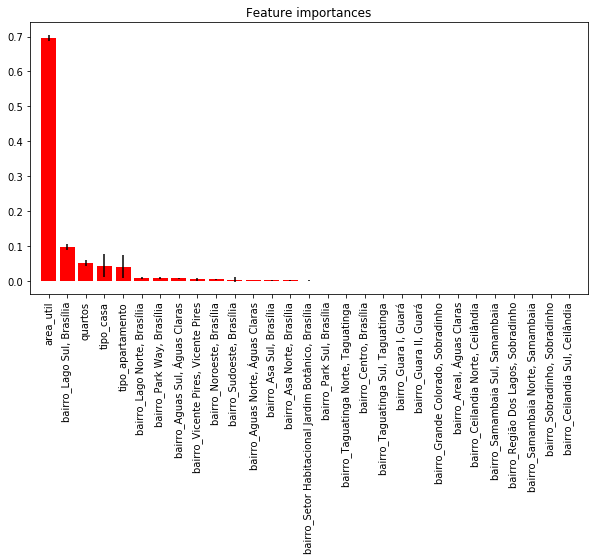

In [31]:
 plt.rcParams['figure.figsize'] = [10, 5]
importances = reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [32]:
reg2 = RandomForestRegressor(n_estimators=100) 

visualizer = ResidualsPlot(reg2)
visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

NameError: name 'ResidualsPlot' is not defined

### TODO: scatterplot valor_venda x area util

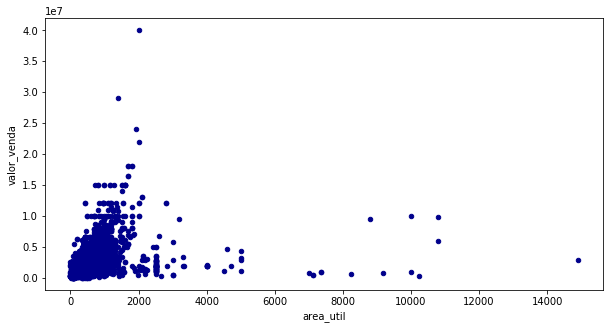

In [33]:

ax1 = df.plot.scatter(x='area_util',
                       y='valor_venda',
                       c='DarkBlue')

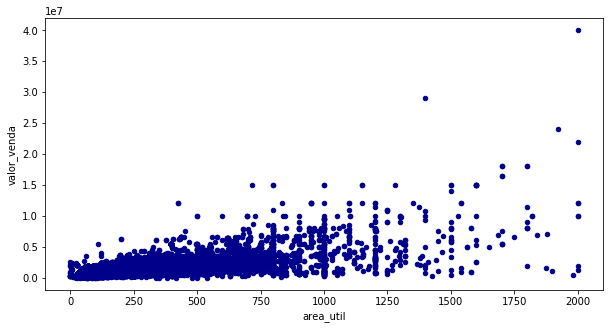

In [34]:
df_zoom = df.loc[df.area_util < 2001]
ax2 = df_zoom.plot.scatter(x='area_util',
                       y='valor_venda',
                       c='DarkBlue')